In [58]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import tensorflow as tf
import keras

In [59]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-Cherry-Leaves'

In [60]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [61]:
current_dir = os.getcwd()
current_dir

'/workspaces'

Model Packages

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

Image Shapes Declaration

In [9]:
import joblib
version = 'v6'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape_1.pkl")
image_shape

(100, 100, 3)

In [10]:
import joblib

# Load the class indices from the saved file
class_indices = joblib.load(f"outputs/v7/class_indices.pkl")
train_set='class_indices'

# Print to check
print(class_indices)

{'healthy': 0, 'powdery_mildew': 1}


Model

In [11]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

Model Summary

In [12]:
create_tf_model().summary()

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 875,777 (3.34 MB)

 Trainable params: 875,777 (3.34 MB)

 Non-trainable params: 0 (0.00 B)

Implementing Early Stopping

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the batch_size
batch_size = 10

# Define train and validation generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
    'inputs/leaves_dataset/cherry-leaves/processed_images/train', 
    target_size=(100, 100), 
    batch_size=batch_size, 
    class_mode='binary'
)

validation_set = validation_datagen.flow_from_directory(
    'inputs/leaves_dataset/cherry-leaves/processed_images/validation', 
    target_size=(100, 100), 
    batch_size=batch_size, 
    class_mode='binary'
)

model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

import pandas as pd

# Train the model and capture the history object
history = model.fit(train_set,
                    epochs=25,
                    steps_per_epoch=len(train_set) // batch_size,
                    validation_data=validation_set,
                    validation_steps=len(validation_set) // batch_size,
                    callbacks=[early_stop],
                    verbose=1)

# Convert the history to a DataFrame
history_df = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
history_df.to_csv('outputs/training_history.csv', index=False)

Found 2944 images belonging to 2 classes.
Found 630 images belonging to 2 classes.
Epoch 1/25


/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


294/294 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - accuracy: 0.7449 - loss: 0.4505 - val_accuracy: 0.9873 - val_loss: 0.0514
Epoch 2/25
  1/294 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.9000 - loss: 0.4209

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9000 - loss: 0.4209 - val_accuracy: 0.9857 - val_loss: 0.0520
Epoch 3/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9836 - loss: 0.0547 - val_accuracy: 0.9937 - val_loss: 0.0146
Epoch 4/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 6.7865e-04 - val_accuracy: 0.9937 - val_loss: 0.0144
Epoch 5/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.9957 - loss: 0.0140 - val_accuracy: 0.9730 - val_loss: 0.0701
Epoch 6/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 0.9746 - val_loss: 0.0677
Epoch 7/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9952 - loss: 0.0262 - val_accuracy: 0.9492 - val_loss: 0.1235
Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9771 - loss: 0.0811 - val_accuracy: 1.0000 - val_loss: 0.0098
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9767 - loss: 0.0354 - val_accuracy: 1.000

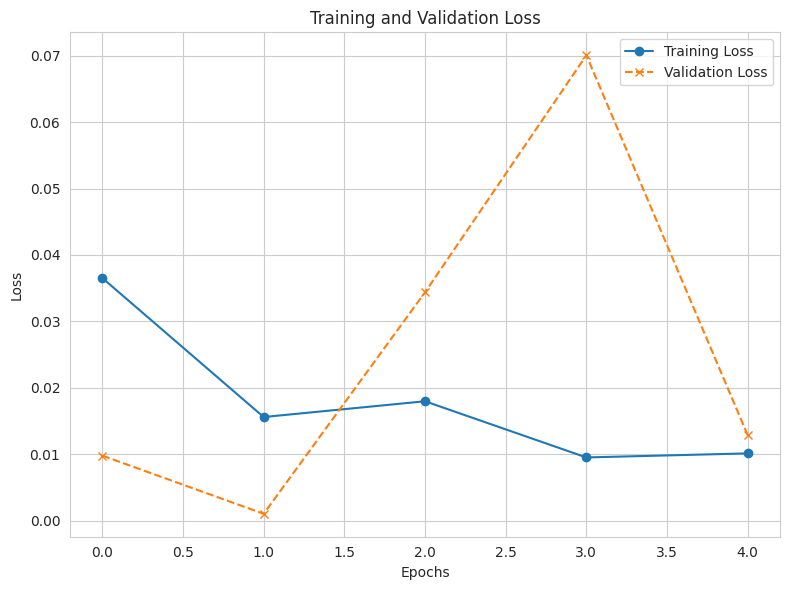

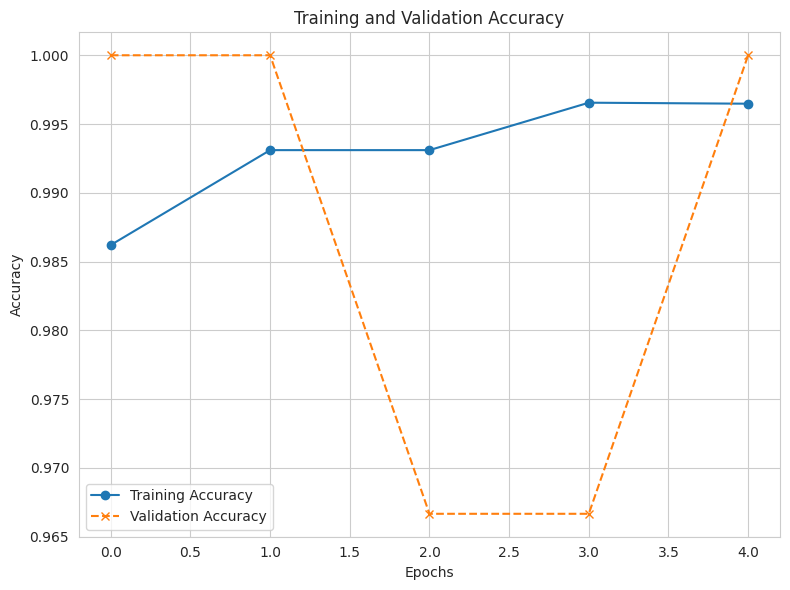

In [15]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a new directory to save the plots, inside 'outputs/v8/'
plots_dir = 'outputs/v8/training_plots'
os.makedirs(plots_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Get the training history
history = model.history.history

# Plot 1: Loss vs. Validation Loss
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
plt.plot(history['loss'], label='Training Loss', linestyle='-', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', linestyle='--', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig(f'{plots_dir}/model_training_loss.png', bbox_inches='tight', dpi=150)
plt.show()

# Plot 2: Accuracy vs. Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history['accuracy'], label='Training Accuracy', linestyle='-', marker='o')
plt.plot(history['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='x')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig(f'{plots_dir}/model_training_accuracy.png', bbox_inches='tight', dpi=150)
plt.show()

In [16]:
from keras.models import load_model
model = load_model('outputs/v8/cherry_leaf_model.h5')

In [17]:
# Ensure that the model is compiled before fitting
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now train the model
history = model.fit(train_set,
                    epochs=25,
                    steps_per_epoch=len(train_set) // batch_size,
                    validation_data=validation_set,
                    validation_steps=len(validation_set) // batch_size,
                    callbacks=[early_stop],
                    verbose=1)

# After training, you can access the metrics in the history object
history_df = pd.DataFrame(history.history)
history_df.to_csv('outputs/training_history.csv', index=False)

Epoch 1/25


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9736 - loss: 0.0673 - val_accuracy: 0.9833 - val_loss: 0.0337
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.9667 - val_loss: 0.0624
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9921 - loss: 0.0627 - val_accuracy: 1.0000 - val_loss: 0.0234
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9985 - loss: 0.0157 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 8.3454e-05
Epoch 6/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9833 - val_loss: 0.1276
Epoch 7/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9867 - loss: 0.0277 - val_accuracy: 1.0000 - val_loss: 6.5571e-04
Epoch 8/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9853 - loss: 0.0501 - val_accuracy: 1.0000 - val_

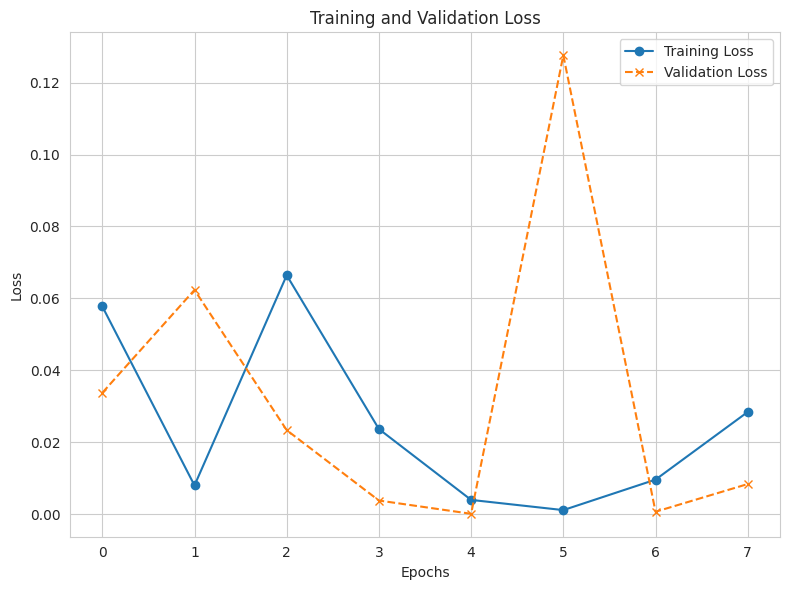

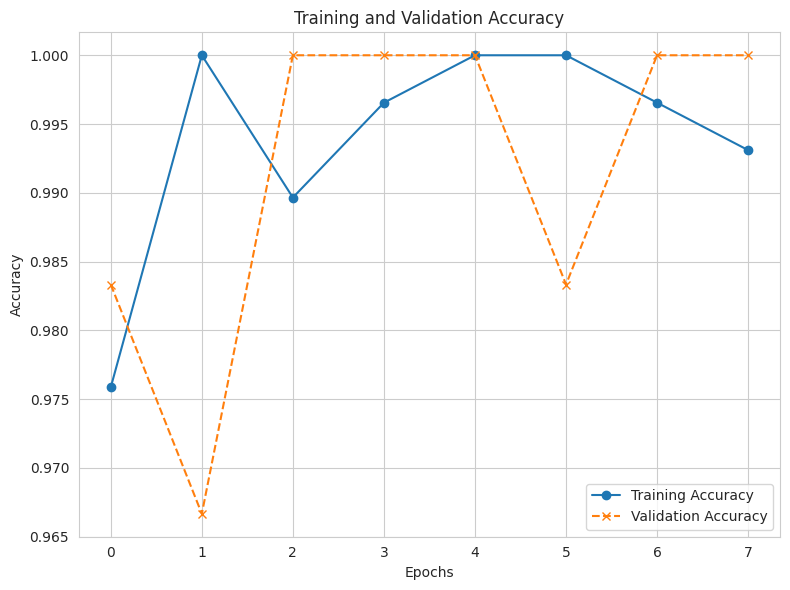

In [18]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract accuracy values (if available)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', linestyle='-', marker='o')
plt.plot(val_loss, label='Validation Loss', linestyle='--', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Plotting accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Training Accuracy', linestyle='-', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', linestyle='--', marker='x')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Evaluate the model on the validation data.
evaluation_metrics = model.evaluate(train_set)

# Output the evaluation result
print(f"Evaluation result: {evaluation_metrics}")

  1/295 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 1.0000 - loss: 0.0026

295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9981 - loss: 0.0082
Evaluation result: [0.010622590780258179, 0.9979619383811951]


In [20]:
# Evaluate the model on the validation data.
evaluation_metrics = model.evaluate(validation_set)

# Output the evaluation result
print(f"Evaluation result: {evaluation_metrics}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9978 - loss: 0.0121
Evaluation result: [0.011919589713215828, 0.9968253970146179]


---

preparing model for analysis on testing dataset which the model has not 'seen'.

In [42]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to your main image folder
image_folder = "inputs/leaves_dataset/cherry-leaves/processed_images/test"  # Change this to your image folder path

# Initialize an empty list to store the images
test_set = []

# Iterate through each folder in the main folder (i.e., 'powdery_mildew', 'healthy')
for class_folder in os.listdir(image_folder):
    class_folder_path = os.path.join(image_folder, class_folder)

    # Skip if it's not a folder
    if os.path.isdir(class_folder_path):
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)

            # Make sure to skip non-image files (e.g., hidden files)
            if os.path.isfile(img_path):
                # Load and preprocess image
                img = image.load_img(img_path, target_size=(100, 100))
                img_array = image.img_to_array(img)  # Convert to numpy array
                test_set.append(img_array)

# Convert the list of images into a numpy array
test_set = np.array(test_set)

print("Shape of test_set:", test_set.shape)  # Should be (num_samples, 100, 100, 3)



Shape of test_set: (634, 100, 100, 3)


In [45]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os
from tensorflow.keras.preprocessing import image

# Assuming `test_set` is already loaded with images (as you have confirmed)
# Initialize lists to collect true labels and predictions
all_preds = []
all_labels = []

batch_size = 10  # Example batch size, adjust as needed

# Define a mapping for labels
class_mapping = {"healthy": 0, "powdery_mildew": 1}

# Create labels for the test_set based on subfolders
test_labels = []

# Loop through each image in test_set and assign the correct label based on its folder
image_folder = "inputs/leaves_dataset/cherry-leaves/processed_images/test"  # Replace with your image folder path
for class_folder in os.listdir(image_folder):
    class_folder_path = os.path.join(image_folder, class_folder)
    if os.path.isdir(class_folder_path):
        label = class_mapping.get(class_folder, -1)  # Get label for class folder
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.isfile(img_path):
                test_labels.append(label)

# Convert labels to numpy array (should match the number of images in test_set)
test_labels = np.array(test_labels)

# Loop through the test set in batches
for i in range(0, len(test_set), batch_size):
    # Get the current batch of images
    batch_X = test_set[i:i + batch_size]
    
    # Get the corresponding batch labels
    batch_y = test_labels[i:i + batch_size]

    # Make predictions for this batch
    raw_preds = model(batch_X)  # Get model predictions (raw output)
    preds = tf.cast(raw_preds >= 0.5, tf.int32).numpy()  # Convert to binary labels (0 or 1)

    # Collect predictions and true labels
    all_preds.extend(preds.flatten())
    all_labels.extend(batch_y.flatten())  # Ensure this matches your label shape

# Now compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

# Generate classification report (precision, recall, F1-score)
class_report = classification_report(all_labels, all_preds)
print("Classification Report:\n", class_report)


Confusion Matrix:
 [[309   8]
 [  1 316]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       317
           1       0.98      1.00      0.99       317

    accuracy                           0.99       634
   macro avg       0.99      0.99      0.99       634
weighted avg       0.99      0.99      0.99       634



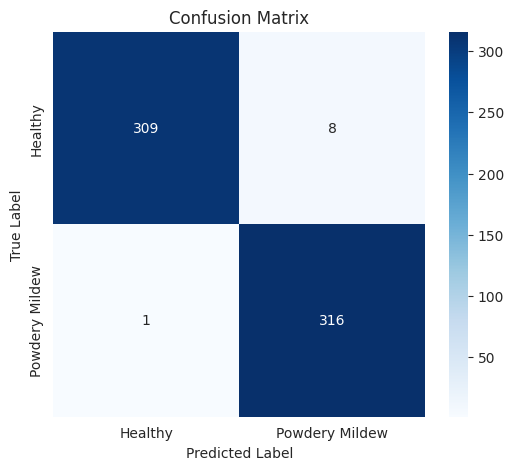

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plotting the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Powdery Mildew"], yticklabels=["Healthy", "Powdery Mildew"])

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [55]:
import pandas as pd

# Prepare the data (can be in a dictionary format)
evaluation_results = {
    'Metric': ['Training Loss', 'Training Accuracy', 'Test Loss', 'Test Accuracy'],
    'Value': [0.0319, 0.9949, 0.0448, 0.9905]
}

# Convert to DataFrame
results_df = pd.DataFrame(evaluation_results)

# Save the DataFrame to a CSV file
results_df.to_csv('outputs/model_evaluation_results.csv', index=False)

# Optionally print the DataFrame
print(results_df)

              Metric   Value
0      Training Loss  0.0319
1  Training Accuracy  0.9949
2          Test Loss  0.0448
3      Test Accuracy  0.9905
